# PREPROCESSING

In [19]:
import cv2
import numpy as np

def preprocess(image):
    image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image_np, (640, 640))
    return image_resized

In [20]:
import cv2
import numpy as np

def preprocess_for_ocr(image_np):
    # Ubah ke grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Denoising
    denoised = cv2.fastNlMeansDenoising(gray, h=8)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        9, 3
    )

    result = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    return result

# OBJECT DETECTION MODEL

In [21]:
!pip install ultralytics

In [22]:
from ultralytics import YOLO

model = YOLO("/kaggle/input/fix_model/other/default/1/best.pt")

In [23]:
def process_model(image):
    image_resized = preprocess(image)
    results = model(image_resized)[0]  # Ambil hasil pertama
    boxes = results.boxes  # Bounding box predictions

    bboxes = boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    classes = boxes.cls.cpu().numpy().astype(int)  # Class index (int)

    # print(f"class: {classes}")
    # print(f"BOX: {bboxes}")
    
    return bboxes, classes

# OCR

In [24]:
!python -m pip install paddlepaddle-gpu==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/
!pip install paddleocr==3.0.0

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu118/


In [25]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_textline_orientation=True, lang='en')

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-LCNet_x0_25_textline_ori', None)
Using official model (PP-LCNet_x0_25_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_mobile_det', None)
Using official model (PP-OCRv5_mobile_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_mobile_rec', None)
Using official model (PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


In [26]:
label_map = {
    0: 'table',
    1: 'not_table'
}

# label_map = {
#     0: 'item_name',
#     1: 'quantity'
#     2: 'price'
# }

In [27]:
import re
from typing import List, Dict, Union, Any

def split_detected_text(detected_text: str) -> List[str]:
    """
    Memecah string panjang hasil OCR menjadi list baris berdasarkan pola 'text price'
    Misalnya: "nasi campur 75,ooo ayam 60,ooo" → ["nasi campur 75,ooo", "ayam 60,ooo"]
    """

    # Cari semua potongan yang diakhiri angka (misal 75,000 / 60.000 / 30.0)
    # Asumsikan bahwa item akan memiliki angka di akhir
    pattern = re.compile(r'(.*?\d[\d.,]*)(?=\s+[a-zA-Z]|$)')
    lines = pattern.findall(detected_text)

    # Bersihkan trailing whitespaces
    lines = [line.strip() for line in lines if line.strip()]
    return lines

In [28]:
def extract_multiple_items_from_line(line: str) -> List[Dict[str, Union[str, int]]]:
    """
    Ekstrak pasangan item dan harga dari satu baris teks OCR.
    Menangani multiple item+price dalam satu baris dengan memanfaatkan regex dan heuristik teks sebelumnya.
    """

    # Cari semua harga di baris (format bebas: 3300, 3,300, 3.300, dst)
    matches = list(re.finditer(r'(\d{1,3}(?:[.,]\d{3})+|\d{4,})', line))

    if not matches:
        return []

    items = []
    last_end = 0

    for match in matches:
        price_str = match.group()
        try:
            price = int(price_str.replace(",", "").replace(".", ""))
        except:
            continue

        # Ambil teks sebelum harga sebagai item
        item_text = line[last_end:match.start()].strip()

        # Hindari item kosong atau angka doang
        if item_text and not item_text.replace(" ", "").isdigit():
            items.append({
                "item_name": item_text,
                "price": price
            })

        last_end = match.end()

    return items


def clean_ocr_text(line: str) -> str:
    # Gabungkan angka yang terpisah spasi: "10 0o0" -> "10000"
    line = re.sub(r'(\d)\s+(\d)', r'\1\2', line)

    # Ganti huruf 'o' atau 'O' yang tertulis sebagai nol
    line = line.replace('o', '0').replace('O', '0')

    return line

def detect_class(lines: List[str]) -> List[Dict]:
    processed_results = []

    for line in lines:
        item_price_pairs = extract_multiple_items_from_line(line)
        if item_price_pairs:
            for pair in item_price_pairs:
                processed_results.append({
                    'class': 'item',
                    'text': pair['item_name']  # ← Fix di sini
                })
                processed_results.append({
                    'class': 'price',
                    'price': pair['price']
                })
        else:
            processed_results.append({
                'class': 'item',
                'text': line
            })

    return processed_results

In [29]:
def reconstruct_items(ner_results: List[Dict]) -> List[Dict]:
    reconstructed = []
    current_item = []
    last_was_item = False
    
    for entry in ner_results:
        if entry['class'] == 'item':
            if not last_was_item and current_item:
                # Jika bertemu item baru, selesaikan item sebelumnya
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            current_item.append(entry['text'])
            last_was_item = True
        else:
            if current_item:
                # Selesaikan item yang sedang dibangun
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            reconstructed.append(entry)  # Tambahkan price/entitas lain
            last_was_item = False
    
    # Tambahkan sisa item jika ada
    if current_item:
        reconstructed.append({
            'class': 'item',
            'text': ' '.join(current_item).strip(),
            'original_parts': current_item.copy()
        })
    
    return reconstructed

def pair_entities(ner_results: List[Dict]) -> List[Dict]:
    """Memasangkan item dan price yang berurutan"""
    paired = []
    i = 0
    n = len(ner_results)
    
    while i < n:
        if ner_results[i]['class'] == 'item':
            item = ner_results[i]['text']
            price = None
            numeric_price = None

            # Cari price berikutnya
            if i + 1 < n and ner_results[i+1]['class'] == 'price':
                price_entry = ner_results[i+1]
                price = price_entry.get('price')  # Akses 'price' jika sudah diganti
                numeric_price = price_entry.get('price')  # Atau akses langsung numeric value

                i += 1  # Lewati price yang sudah diproses
            
            paired.append({
                'item_name': item,
                'price': numeric_price
            })
        i += 1
    
    return paired


def is_noise(text: str) -> bool:
    """
    Mengecek apakah suatu teks termasuk 'noise' (bukan item menu, misalnya total, service, dll)
    """
    noise_keywords = [
        'subtotal', 'sub total', 'service', 'tax', 'pajak', 'pb1', 't0tal', 'subt0tal',
        'r0unding','disk0n','disc0unt', 'vc', 'vc pt'
        'rounding', 'diskon', 'discount', 'total', 'grand total', 'change', 'kembalian', 'srand tl'
    ]
    text = text.lower()
    return any(keyword in text for keyword in noise_keywords)


def is_short_or_symbol(text: str, min_length=3) -> bool:
    """Check if text is too short or just symbols/numbers."""
    stripped = text.strip()
    # Skip if:
    # - Length < min_length (default: 3)
    # - Only digits/symbols (e.g., "1", "A", ",M")
    return (
        len(stripped) < min_length or
        stripped.isdigit() or
        (len(stripped) == 1 and not stripped.isalpha())
    )

In [30]:
def normalize_price_typo(text: str) -> str:
    typo_map = {
        'b': '8',
        'B': '8',
        'o': '0',
        'O': '0',
        'l': '1',
        'I': '1',
        'i': '1',
        's': '5',
        'S': '5',
        'z': '2',
        'Z': '2',
    }
    return ''.join(typo_map.get(c, c) for c in text)


def extract_tax_lines_with_context(rec_texts, tax_keywords=None):
    if tax_keywords is None:
        tax_keywords = ["ppn", "pajak", "tax", "pjk", "service", "serv", "pb", "charge", "chrg"]

    tax_lines = []
    tax_amounts = []

    n = len(rec_texts)

    for i, line in enumerate(rec_texts):
        lower_line = line.lower()

        if any(k in lower_line for k in tax_keywords):
            tax_lines.append(line)
            found = False

            # ✅ Cari angka yang terkait keyword di baris ini
            matches = extract_tax_values_from_line_by_keyword(line, tax_keywords)
            tax_amounts.extend(matches)
            found = bool(matches)

            # Kalau belum ketemu, cek baris setelah
            if not found and i + 1 < n:
                next_line = rec_texts[i + 1]
                amount = extract_price_like_from_line(next_line)
                if amount is not None:
                    tax_amounts.append(amount)
                    tax_lines.append(next_line)
                    found = True

            # Kalau masih belum, cek baris sebelum
            if not found and i - 1 >= 0:
                prev_line = rec_texts[i - 1]
                amount = extract_price_like_from_line(prev_line)
                if amount is not None:
                    tax_amounts.append(amount)
                    tax_lines.append(prev_line)

    return tax_lines, tax_amounts


def extract_tax_values_from_line_by_keyword(line, tax_keywords):
    tax_amounts = []
    lower_line = line.lower()

    for keyword in tax_keywords:
        pattern = rf"{keyword}\s*[:=]?\s*([\d.,]+)"
        matches = re.findall(pattern, lower_line)
        for raw_amt in matches:
            if "%" in raw_amt:
                continue
            if is_price_like_number(raw_amt):
                amt = int(raw_amt.replace(",", "").replace(".", ""))
                tax_amounts.append(amt)

    return tax_amounts


def extract_price_like_from_line(line):
    line = normalize_price_typo(line)
    match = re.search(r"([\d.,]+)", line)
    if match:
        raw = match.group(1)
        if "%" in raw:
            return None
        if is_price_like_number(raw):
            return int(raw.replace(",", "").replace(".", ""))
    return None


def is_price_like_number(s: str, min_val: int = 100):
    s_clean = s.replace(",", "").replace(".", "")
    if not s_clean.isdigit():
        return False
    try:
        val = int(s_clean)
        return val >= min_val
    except:
        return False

In [31]:
def clean_item_name(name: str) -> str:
    """Clean item names by removing non-alphanumeric characters from start/end"""
    return re.sub(r"^[^\w\d]+|[^\w\d]+$", "", name.strip())

In [32]:
def process_receipt_data_with_ner(ner_results: List[Dict], rec_texts: Any) -> Dict:
    """Process receipt data and extract total/tax info from OCR."""
    reconstructed = reconstruct_items(ner_results)
    paired = pair_entities(reconstructed)

    valid_items = []
    discount_keywords = {"uc", "vc", "vc pt", "disc", "voucher", "diskon", "discount"}
    
    i = 0
    n = len(paired)

    while i < n:
        current_item = paired[i]
        current_item['item_name'] = clean_item_name(current_item['item_name'])

        if not current_item['item_name'] or not current_item['price'] or is_noise(current_item['item_name']) or is_short_or_symbol(current_item['item_name']):
            i += 1
            continue

        item_name_lower = current_item['item_name'].lower()

        if i + 1 < n:
            next_item = paired[i + 1]
            next_text = next_item['item_name'].lower()

            if any(keyword in next_text for keyword in discount_keywords):
                current_item['price'] -= next_item['price']
                i += 1

        if isinstance(current_item['price'], (int, float)):
            current_item['price'] = abs(current_item['price'])
        else:
            i += 1
            continue
            
        valid_items.append(current_item)
        i += 1

    # Use original lines (not lowercased) to preserve tax keywords
    tax_lines, tax_amounts = extract_tax_lines_with_context(rec_texts)
    # Print hasil
    print("Baris pajak terdeteksi:")
    for line in tax_lines:
        print(f" - {line}")

    return {
        'status': 'success',
        'tax': sum(tax_amounts),
        'items': valid_items
    }

In [33]:
import numpy as np
import cv2
import os

# Inisialisasi OCR
keywords = ['total', 'subtotal', 'amount', 'jumlah', 't0tal', 'subt0tal']

def crop_image_by_bbox(image: np.ndarray, bbox: list) -> np.ndarray:
    height, width = image.shape[:2]

    if len(bbox) == 4:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(max(0, min(x_min, width - 1)))
        x_max = int(max(0, min(x_max, width - 1)))
        y_min = int(max(0, min(y_min, height - 1)))
        y_max = int(max(0, min(y_max, height - 1)))

        cropped_image = image[y_min:y_max, x_min:x_max]
        return cropped_image

    elif len(bbox) == 8:
        pts = np.array(bbox, dtype=np.float32).reshape(-1, 2)
        dst_pts = np.array([[0, 0], [639, 0], [639, 639], [0, 639]], dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(pts, dst_pts)
        cropped_image = cv2.warpPerspective(image, matrix, (640, 640))
        return cropped_image

    else:
        raise ValueError("Format bbox tidak valid.")

def read_image(image):
    preprocessed = preprocess(image)
    boxes, classes = process_model(preprocessed)

    print("Langsung cek keyword dari OCR global...")

    preprocessed_ocr = preprocess_for_ocr(preprocessed)

    # Gunakan OCR global
    ocr_global = ocr.predict(preprocessed_ocr)
    
    # If ocr_result is a list containing one dict
    if isinstance(ocr_global, list) and len(ocr_global) > 0:
        ocr_global = ocr_global[0]
    
    # Now access rec_texts
    rec_texts = ocr_global['rec_texts']
    detected_global_lower = " ".join([t.lower() for t in rec_texts if t.strip()])

    detected_lines = []
    
    if any(keyword in detected_global_lower for keyword in keywords):
        print("Keyword ditemukan. Proses ekstraksi data receipt...")

        for idx, bbox in enumerate(boxes):
            try:
                cropped_image = crop_image_by_bbox(preprocessed_ocr, bbox)
                ocr_result = ocr.predict(cropped_image)
                if ocr_result and isinstance(ocr_result, list) and len(ocr_result) > 0:
                    ocr_result = ocr_result[0]  # Get the first (and usually only) result dict
                    
                    # Extract text line by line
                    for text in ocr_result['rec_texts']:
                        if text.strip():  # Skip empty lines
                            detected_lines.append(text)  # Append the recognized text
                
                    # (Optional) Get bounding boxes for each line (if needed)
                    # line_bboxes = ocr_result['dt_polys']  # List of bounding boxes (if required)

            except ValueError as e:
                print(f"Error dalam cropping gambar: {e}")
                continue

        detected_text_lower = " ".join([t.lower() for t in detected_lines])
        print(detected_text_lower)

        lines = split_detected_text(detected_text_lower)
        ner_results = detect_class(lines)
        final_result = process_receipt_data_with_ner(ner_results, rec_texts)

        print("SPLIT lines:", lines)
        print("NER results:", ner_results)
        print("FINAL:", final_result)

        return final_result

    print("Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.")
    return {
        "status": "not_receipt_invoice",
        "error_msg": "Gambar yang Anda masukkan bukan receipt/invoice."
    }


# TEST

In [34]:
def crop_and_save(image, boxes, output_folder="cropped_images", prefix="img"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for idx, bbox in enumerate(boxes):
        try:
            save_path = os.path.join(output_folder, f"{prefix}_crop_{idx}.jpg")
            crop_image_by_bbox(image, bbox, save_path)
        except ValueError as e:
            print(f"Cropping gagal: {e}")

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_boxes_safe(image, boxes, classes, label_map, i):
    save_path = f"output_with_boxes{i}.jpg"
    image = preprocess(image)
    preprocessed_ocr = preprocess_for_ocr(image)
    image_vis = preprocessed_ocr.copy()
    height, width = preprocessed_ocr.shape[:2]

    for box, cls_id in zip(boxes, classes):
        cls_name = label_map[int(cls_id)]
        color = (0, 255, 0)
        thickness = 2

        try:
            if len(box) == 4:
                # Box = [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)
                x1 = max(0, min(x1, width - 1))
                x2 = max(0, min(x2, width - 1))
                y1 = max(0, min(y1, height - 1))
                y2 = max(0, min(y2, height - 1))
                cv2.rectangle(image_vis, (x1, y1), (x2, y2), color, thickness)
                cv2.putText(image_vis, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            elif len(box) == 8:
                # Box = quadrilateral [x1, y1, x2, y2, x3, y3, x4, y4]
                pts = np.array(box, dtype=np.int32).reshape(-1, 2)
                pts[:, 0] = np.clip(pts[:, 0], 0, width - 1)
                pts[:, 1] = np.clip(pts[:, 1], 0, height - 1)
                cv2.polylines(image_vis, [pts], isClosed=True, color=color, thickness=2)
                cv2.putText(image_vis, cls_name, tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        except Exception as e:
            print(f"Gagal menggambar box: {box}, error: {e}")
            continue

    # Simpan dan tampilkan
    cv2.imwrite(save_path, image_vis)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected BBoxes")
    plt.axis("off")
    plt.show()



--- Gambar ke-1 (contoh-2.jpeg) ---

0: 640x640 (no detections), 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


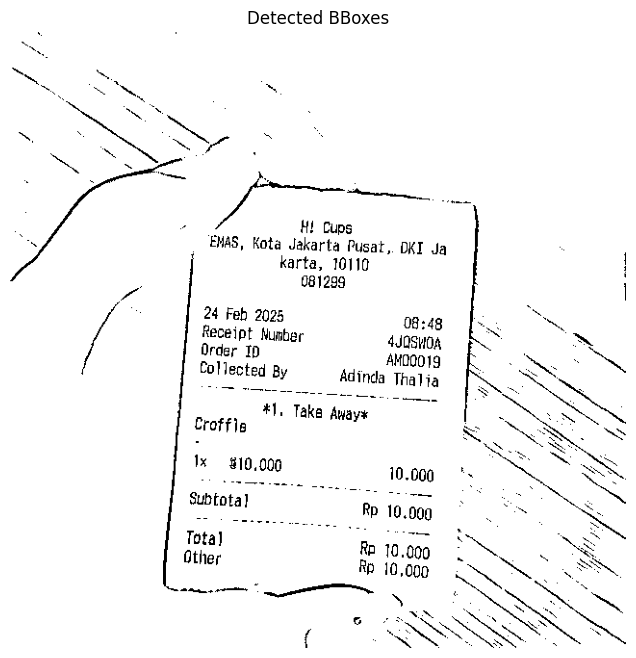


0: 640x640 (no detections), 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...

Baris pajak terdeteksi:
SPLIT lines: []
NER results: []
FINAL: {'status': 'success', 'tax': 0, 'items': []}
{'status': 'success', 'tax': 0, 'items': []}

--- Gambar ke-2 (contoh-4.jpeg) ---

0: 640x640 1 table, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


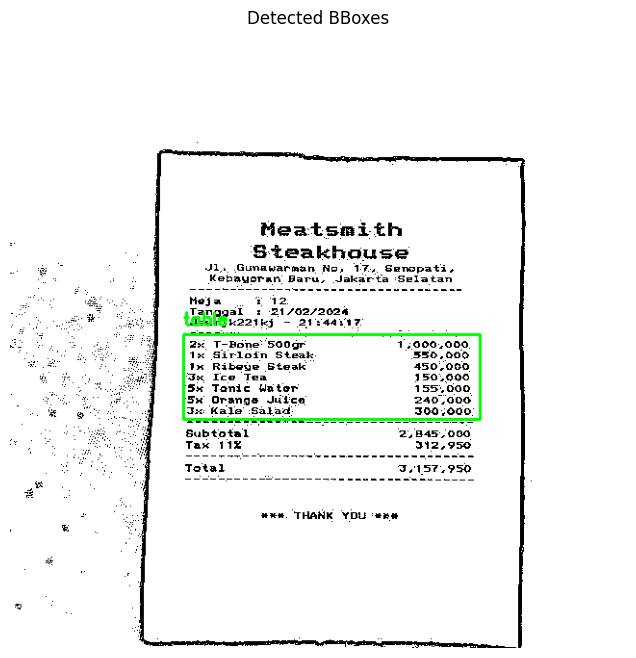


0: 640x640 1 table, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
2x t-bone 500gr 1 000000 x sirlofn steak 550.000 x riboye gteak 450000 xx ice jea 150000 tonic wator juico 155000 x orango 240.000 kale:salad 0000
Baris pajak terdeteksi:
 - Tax11x
 - 312.950
SPLIT lines: ['2x t-bone 500gr 1 000000', 'x sirlofn steak 550.000', 'x riboye gteak 450000', 'xx ice jea 150000', 'tonic wator juico 155000', 'x orango 240.000', 'kale:salad 0000']
NER results: [{'class': 'item', 'text': '2x t-bone 500gr 1'}, {'class': 'price', 'price': 0}, {'class': 'item', 'text': 'x sirlofn steak'}, {'class': 'price', 'price': 550000}, {'class': 'item', 'text': 'x riboye gteak'}, {'class': 'price', 'price': 450000}, {'class': 'item', 'text': 'xx ice jea'}, {'class': 'price', 'price': 150000}, {'class': 'item', 'text': 'tonic wator juico'}, {'class': 'price', 'price'

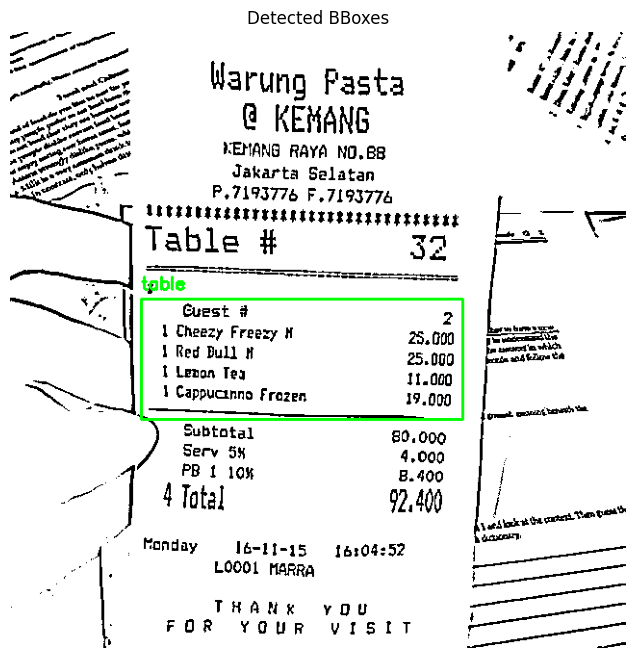


0: 640x640 1 table, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
guest 计 cheezy freezy h 25.00 red bull h 25.000 ledon tea 11.000 i cappucinno frozen 19.000
Baris pajak terdeteksi:
 - Serv 5%
 - B.400
 - PB 1 10%
 - 92.400
SPLIT lines: ['guest 计 cheezy freezy h 25.00', 'red bull h 25.000', 'ledon tea 11.000', 'i cappucinno frozen 19.000']
NER results: [{'class': 'item', 'text': 'guest 计 cheezy freezy h 25.00'}, {'class': 'item', 'text': 'red bull h'}, {'class': 'price', 'price': 25000}, {'class': 'item', 'text': 'ledon tea'}, {'class': 'price', 'price': 11000}, {'class': 'item', 'text': 'i cappucinno frozen'}, {'class': 'price', 'price': 19000}]
FINAL: {'status': 'success', 'tax': 100800, 'items': [{'item_name': 'guest 计 cheezy freezy h 25.00 red bull h', 'price': 25000}, {'item_name': 'ledon tea', 'price': 8000}]}
{'status': 'success', '

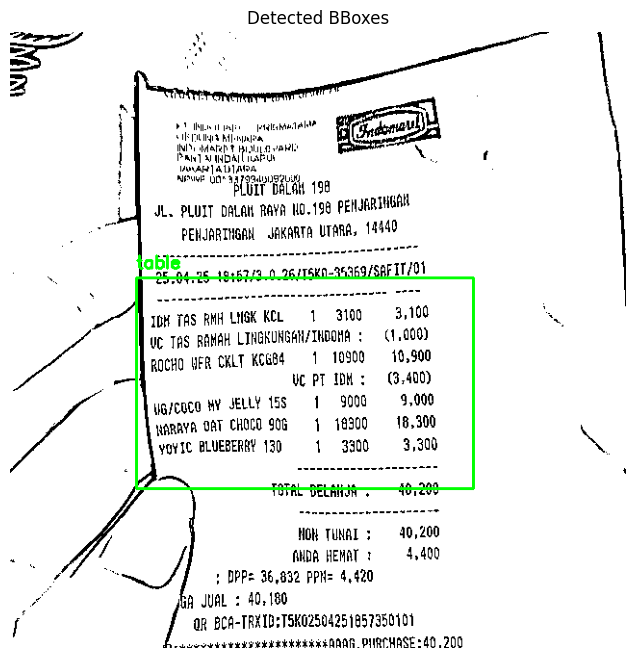


0: 640x640 1 table, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Keyword ditemukan. Proses ekstraksi data receipt...
------------------------------- -- - idm tas rmh liigk kcl 1 3100 3,100 uc jas ramah lingkungah/ihdoha: (1.000) rocho ufr cklt kcgb4 1 10900 10,900 vc pt idm: (3,400) 1g/coco my jelly 15s 1 9000 9,000 narrya oat choco 90g 1 18300 18,300 yoyic blueberby 130 1 3300 3,300
Baris pajak terdeteksi:
 - :DPP=36,832PPN=4.420
SPLIT lines: ['------------------------------- -- - idm tas rmh liigk kcl 1 3100 3,100', 'uc jas ramah lingkungah/ihdoha: (1.000) rocho ufr cklt kcgb4 1 10900 10,900', 'vc pt idm: (3,400) 1g/coco my jelly 15s 1 9000 9,000', 'narrya oat choco 90g 1 18300 18,300', 'yoyic blueberby 130 1 3300 3,300']
NER results: [{'class': 'item', 'text': '------------------------------- -- - idm tas rmh liigk kcl 1'}, {'class': 'price', 'price': 3100}, {'class': 'item', 'text': 'u

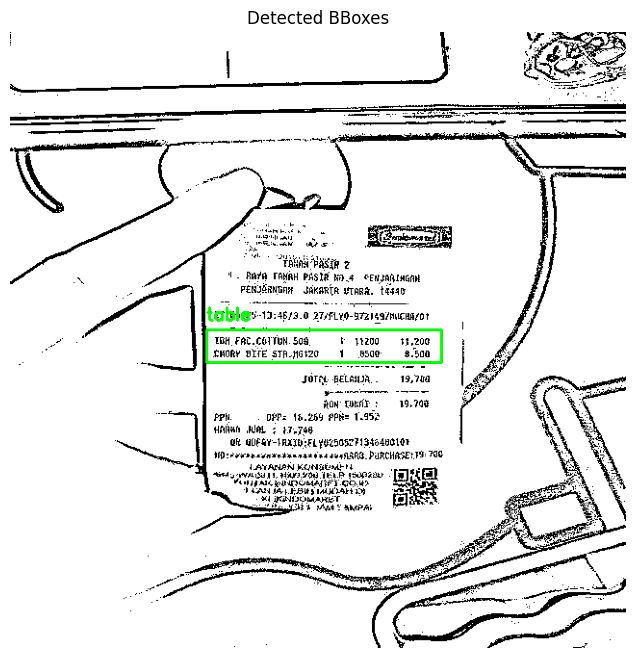


0: 640x640 1 table, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.
{'status': 'not_receipt_invoice', 'error_msg': 'Gambar yang Anda masukkan bukan receipt/invoice.'}


In [36]:
import os
from PIL import Image
import numpy as np

# Path ke folder gambar
# folder_path = "/kaggle/input/test-image"
folder_path = "/kaggle/input/test-image"

# Dapatkan daftar file gambar dengan ekstensi tertentu
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for i, filename in enumerate(image_files):
    image_path = os.path.join(folder_path, filename)
    try:
        # Buka gambar dan konversi ke array NumPy
        image_pil = Image.open(image_path).convert("RGB")
        image_np = np.array(image_pil)

        print(f"\n--- Gambar ke-{i+1} ({filename}) ---")

        # 1. Model deteksi objek
        boxes, classes = process_model(image_np)

        # 2. Visualisasi (opsional)
        visualize_boxes_safe(image_np, boxes, classes, label_map, i)

        # 3. OCR
        result = read_image(image_np)
        print(result)

    except Exception as e:
        print(f"❌ Gagal memproses {filename}: {e}")